In [40]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee
from astropy.time import Time
from mc3.stats import time_avg
import h5py
import corner
from matplotlib.ticker import ScalarFormatter

In [6]:
eclipses = ['1', '2', '3']
a = '5'
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {e: [] for e in eclipses}
aplev_arr = {e: [] for e in eclipses}
aperr_arr = {e: [] for e in eclipses}
centroid_x_arr = {e: [] for e in eclipses}
centroid_y_arr = {e: [] for e in eclipses}


for e in eclipses:
    for seg in segments:
        if e == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[e] = np.append(time_arr[e], np.array(file['time']))
            aplev_arr[e] = np.append(aplev_arr[e], np.array(file['aplev']))
            aperr_arr[e] = np.append(aperr_arr[e], np.array(file['aperr']))
            centroid_x_arr[e] = np.append(centroid_x_arr[e], np.array(file['centroid_x']))
            centroid_y_arr[e] = np.append(centroid_y_arr[e], np.array(file['centroid_y']))

    time_arr[e] = np.array(time_arr[e])
    aplev_arr[e] = np.array(aplev_arr[e])
    aperr_arr[e] = np.array(aperr_arr[e])
    centroid_x_arr[e] = np.array(centroid_x_arr[e])
    centroid_y_arr[e] = np.array(centroid_y_arr[e])

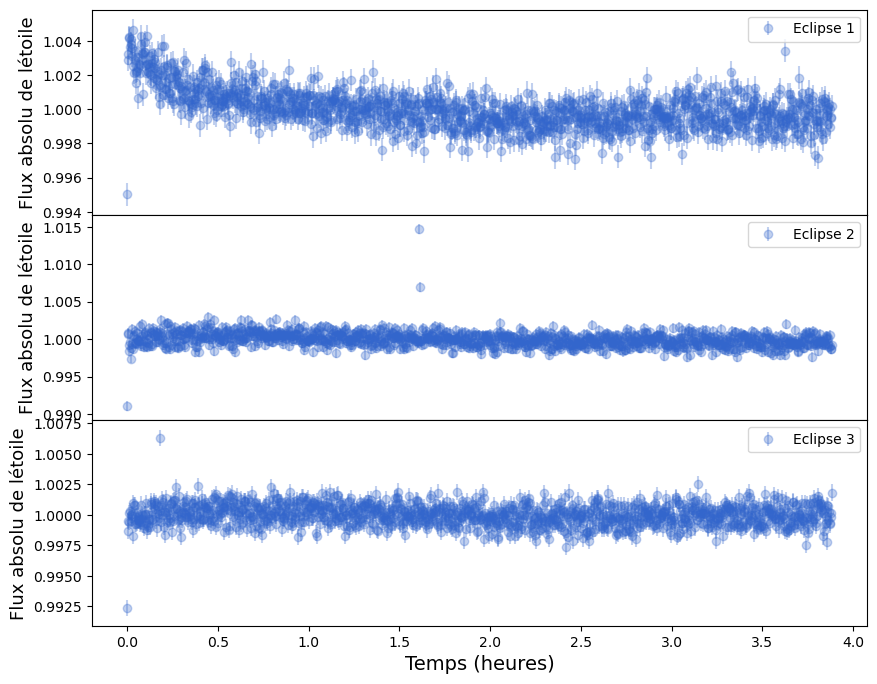

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
aperr_norm = {}
aplev_norm = {}
for i, e in enumerate(eclipses):
    aperr_norm[e] = aperr_arr[e]/np.mean(aplev_arr[e])
    aplev_norm[e] = aplev_arr[e]/np.mean(aplev_arr[e])
    ax[i].errorbar((time_arr[e]-time_arr[e][0])*24, aplev_norm[e], yerr=aperr_norm[e], fmt='o', label='Eclipse '+e, alpha=0.3, color='#3366cc')
    ax[i].set_ylabel('Flux absolu de l''étoile', fontsize=13)
    # make labelfont size bigger
    ax[i].legend()
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False)
ax[2].set_xlabel('Temps (heures)', fontsize=14)
plt.subplots_adjust(hspace=0)
#plt.tight_layout()
plt.show()

In [82]:
# All the astrophysical and noise models are defined here to be used in the analysis.
# There are different options for the noise model, and they can be combined with the a second-order polynomial model for the centroids

def transit_model(time, t_s, fp):
    # this model is based on the batman package
    # fits specifically for secondary eclipses
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                        #time of inferior conjunction
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def signal(time, centroid_x, centroid_y, theta, model_type):
    t_s = theta[0]
    fp = theta[1]
    astro = transit_model(time, t_s, fp)

    time_segment_1 = time[:len1]
    time_segment_2 = time[len1:len1+len2]
    time_segment_3 = time[len1+len2:]
    centroid_x_segment_1 = centroid_x[:len1]
    centroid_x_segment_2 = centroid_x[len1:len1+len2]
    centroid_x_segment_3 = centroid_x[len1+len2:]
    centroid_y_segment_1 = centroid_y[:len1]
    centroid_y_segment_2 = centroid_y[len1:len1+len2]
    centroid_y_segment_3 = centroid_y[len1+len2:]
    
    # for model in model_type:
    #     if '2nd_order_centroid' in model:
    #         detec_centroid = detec_model_poly(centroid_x, centroid_y, theta[2], theta[3], theta[4], theta[5], theta[6], theta[7])
    #         theta = np.delete(theta, np.s_[2:8])
    #         model = model.replace('_2nd_order_centroid', '')  # Remove for processing
    #         centroid = True

    #     if model == 'exp+linear':
    #         t_s, fp, c1, c2, c3, c4, c5, sigF = theta
    #         detec = exponential_func(time, c1, c2, c3)*linear_slope(time, c4, c5)
    #     elif model == 'exp':
    #         t_s, fp, c1, c2, c3, sigF = theta
    #         detec = exponential_func(time, c1, c2, c3)
    #     elif model == 'linear':
    #         t_s, fp, c1, c2, sigF = theta
    #         detec = linear_slope(time, c1, c2)
    #     elif model == 'polynomial':
    #         t_s, fp, c1, c2, c3, c4, sigF = theta
    #         detec = poly_3rd_degree(time, c1, c2, c3, c4)
    #     elif model == 'exp+polynomial':
    #         t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
    #         detec = exponential_func(time, c1, c2, c3)*poly_3rd_degree(time, c4, c5, c6, c7)
    #     elif model == 'linear+polynomial':
    #         t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
    #         detec = linear_slope(time, c1, c2)*poly_3rd_degree(time, c3, c4, c5, c6)
    #     elif model == 'double_exp':
    #         t_s, fp, c1, c2, c3, c4, sigF = theta
    #         detec = double_exponential(time, c1, c2, c3, c4)
    #             # Multiply the instrumental noise model with the centroid model
    #     if centroid:
    #         detec = detec * detec_centroid

    #test_theta = ['ts', 'fp','e1_exp_c1', 'e1_exp_c2', 'e1_exp_c3', 'e1_c1', 'e1_c2', 'e1_c3', 'e1_c4', 'e1_c5', 'e1_c6', 'e2_dexp_c1', 'e2_dexp_c2', 'e2_dexp_c3', 'e2_dexp_c4', 'e2_c1', 'e2_c2', 'e2_c3' 'e2_c4', 'e2_c5', 'e2_c6', 'e3_exp_c1', 'e3_exp_c2', 'e3_exp_c3', 'e3_c1', 'e3_c2', 'e3_c3', 'e3_c4', 'e3_c5', 'e3_c6']

    result1 = detec_model_poly(centroid_x_segment_1, centroid_y_segment_1, *theta[2:8]) * exponential_func(time_segment_1-time_segment_1[0], *theta[8:11])
    result2 = detec_model_poly(centroid_x_segment_2, centroid_y_segment_2, *theta[11:17]) * double_exponential(time_segment_2-time_segment_2[0], *theta[17:21]) 
    result3 = detec_model_poly(centroid_x_segment_3, centroid_y_segment_3, *theta[21:27]) * exponential_func(time_segment_3-time_segment_3[0], *theta[27:30])
    detec = np.concatenate([result1, result2, result3])

    return astro*detec

# bin the data
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

# retrieve proper errorbars on aplev
def binFluxError(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)

    return binned, binnedErr

# plotting functions
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

In [108]:
test_theta = ['ts', 'fp', 'e1_c1', 'e1_c2', 'e1_c3', 'e1_c4', 'e1_c5', 'e1_c6', 'e1_exp_c1', 'e1_exp_c2', 'e1_exp_c3', 'e2_c1', 'e2_c2', 'e2_c3', 'e2_c4', 'e2_c5', 'e2_c6', 'e2_dexp_c1', 'e2_dexp_c2', 'e2_dexp_c3', 'e2_dexp_c4',  'e3_c1', 'e3_c2', 'e3_c3', 'e3_c4', 'e3_c5', 'e3_c6', 'e3_exp_c1', 'e3_exp_c2', 'e3_exp_c3', 'sigF']
test_theta[27:30]

['e3_exp_c1', 'e3_exp_c2', 'e3_exp_c3']

In [109]:
def log_likelihood(theta, time, flux, centroid_x, centroid_y, model_type):
    model = signal(time, centroid_x, centroid_y, theta, model_type)
    sigF = theta[-1]
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    prior = 0.
    t_s = theta[0]
    fp = theta[1]
    sigF = theta[-1]
    if (0 < fp < 1 and (ecl-(e_dur/2)) < t_s < (ecl+(e_dur/2)) and sigF > 0. ): 
        return 0.0 + prior
    return np.inf

def log_prob(theta, time, flux, centroid_x, centroid_y, model_type):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, centroid_x, centroid_y, model_type)

1260 1260 1260 3780 3780
0.09827457404753659
2.358589777140878 47.69218977706623


Text(0.5, 0, 'Time (days)')

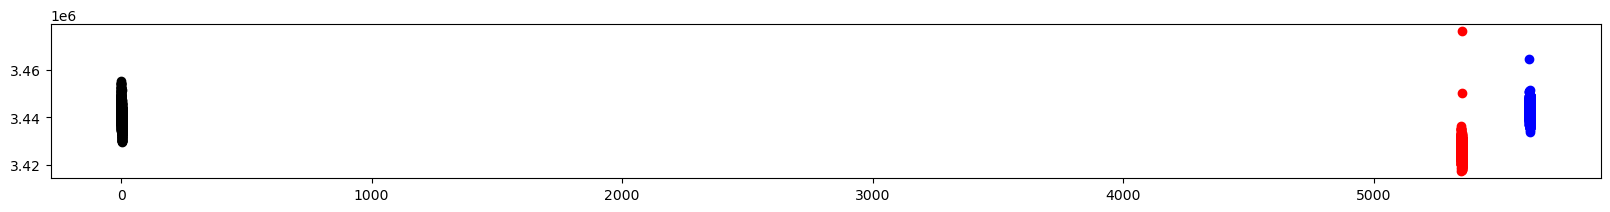

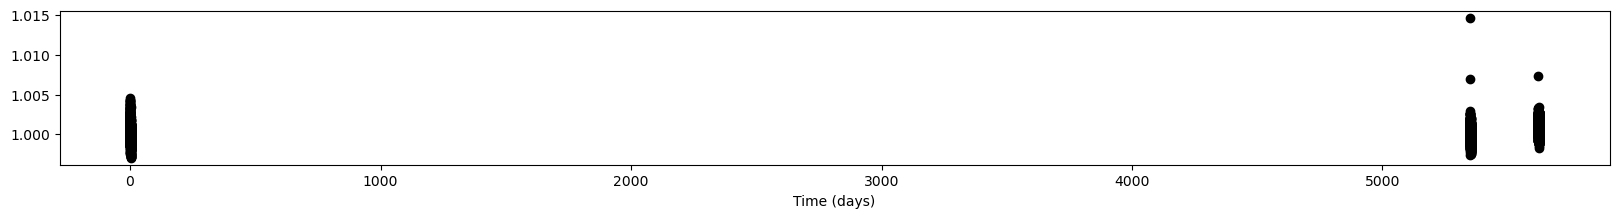

In [9]:
ndiscard = 2
len1 = len(time_arr['1'])-ndiscard
len2 = len(time_arr['2'])-ndiscard
len3 = len(time_arr['3'])-ndiscard
# starting points
# e1 = 0
# e2 = len1
# e3 = len1 + len2
time = np.concatenate((time_arr['1'][ndiscard:], time_arr['2'][ndiscard:], time_arr['3'][ndiscard:]))
aplev = np.concatenate((aplev_arr['1'][ndiscard:]/np.mean(aplev_arr['1'][ndiscard:]), aplev_arr['2'][ndiscard:]/np.mean(aplev_arr['2'][ndiscard:]), aplev_arr['3'][ndiscard:]/np.mean(aplev_arr['1'][ndiscard:])))
aperr = np.concatenate((aperr_norm['1'][ndiscard:], aperr_norm['2'][ndiscard:], aperr_norm['3'][ndiscard:]))
#aplev = aplev / np.mean(aplev)
centroid_x = np.concatenate((centroid_x_arr['1'][ndiscard:], centroid_x_arr['2'][ndiscard:], centroid_x_arr['3'][ndiscard:]))
centroid_y = np.concatenate((centroid_y_arr['1'][ndiscard:], centroid_y_arr['2'][ndiscard:], centroid_y_arr['3'][ndiscard:]))

print(len1, len2, len3, (len1+len2+len3), len(time))

ecl = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
ecl = ecl.mjd
print(ecl-time[0])
t_s = (60275.875-time[0])*(24)
ecl = t_s
t0 = (58388.7939-time[0])*(24)
e_dur = 1.13 # expected eclipse duration in hours
per = 3.777940*24
t0 = t0+(per*500)
print(t_s, t0)
fp = 0.000230
p0_astro = np.array([t_s, fp]) 
time = (time - time[0])*(24)

plt.figure(figsize=(20, 2))
plt.plot(time[0:len1], aplev_arr['1'][ndiscard:], 'ok')
plt.plot(time[len1:(len1+len2)], aplev_arr['2'][ndiscard:], 'or')
plt.plot(time[(len1+len2):], aplev_arr['3'][ndiscard:], 'ob')
plt.figure(figsize=(20, 2))
plt.plot(time, aplev, 'ok')
plt.xlabel('Time (days)')

In [38]:
(2.2778170852557573-2.358589777140878)*60
0.846361513107249*60

50.78169078643494

In [17]:
# Split the time array
time_segment_1 = time[:len1]
time_segment_2 = time[len1:len1+len2]
time_segment_3 = time[len1+len2:]
aplev_segment_1 = aplev[:len1]
aplev_segment_2 = aplev[len1:len1+len2]
aplev_segment_3 = aplev[len1+len2:]
centroid_x_segment_1 = centroid_x[:len1]
centroid_x_segment_2 = centroid_x[len1:len1+len2]
centroid_x_segment_3 = centroid_x[len1+len2:]
centroid_y_segment_1 = centroid_y[:len1]
centroid_y_segment_2 = centroid_y[len1:len1+len2]
centroid_y_segment_3 = centroid_y[len1+len2:]


(0.999, 1.001)

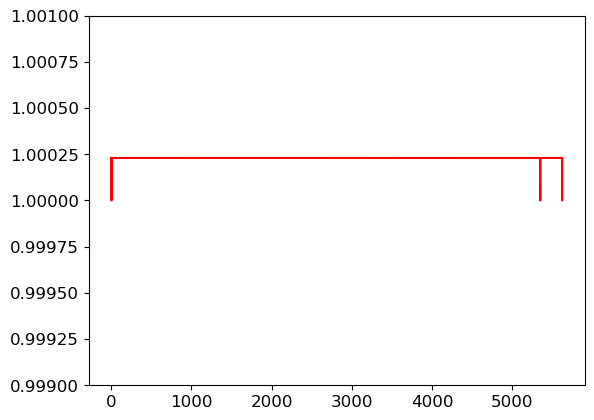

In [112]:
flux = transit_model(time, t_s, fp)

plt.plot(time, flux, '-r')
plt.ylim(0.999, 1.001)
#plt.xlim(-1, 5)
#plt.xlim(5340, 5360)
#plt.xlim(5620, 5630)

In [113]:
# set p0 as best fit MCMC results
# IMPROVEMENT: write a code that automatically reads the best fit file (from BIC comparison, same as compare plot function to fill these automatically)
#p0_astro = [2.2840699031857015, 0.0002821004349741118] # use this to start from previous MCMC results  

p0_e1 = [-2.5724076452280684, -6.389941025254419, 6.525492587736043 , 0.7233170877339714 , -1.4045958036658905  , 0.6804574248204798  , 0.0032785998747512667 , 2.12042817557747  , 0.9432017891049531]
p0_e2 = [44.56201971097679, -24.460866465769136 , 23.8029892155267 , -0.8843578598497892 , 1.9630156782068546, -1.0761082178955563, -0.00016421817496860145 , 2.8786894131425216  , 0.4646110562070881  , 0.00014283535327202482 ]
p0_e3 = [-1432.5971375017543  , 389.08739802377727 , -366.1894259139327, -2.8821534313841304  , 2.6674253160190737  , 0.123305624488241  , -0.13713369330766617  , -0.0005126665555101235  , 0.9984998894935644]

p0 = np.concatenate((p0_astro, p0_e1, p0_e2, p0_e3, [0.001]))
model_type = ['exp_2nd_order_centroid','double_exp_2nd_order_centroid','exp_2nd_order_centroid']


In [114]:
nsteps, nwalkers, ndim = 100000, 70, len(p0)

# lower the initial position scatter
pos = p0 + 1e-4 * np.random.randn(nwalkers, ndim)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y)) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y, model_type))

pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 100000/100000 [1:23:39<00:00, 19.92it/s] 


In [115]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

try_nb='4' # 4

# Save the chains
savepath = 'Final_Joint_results/try'+try_nb+'_'
pathchain = savepath + 'samplerchain_10000.npy'
pathlnlchain = savepath + 'samplerlnlchain_10000.npy'
pathposit = savepath + 'samplerposi_10000.npy'
pathlnpro = savepath + 'samplerlnpr_10000.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

In [3]:
try_nb='3'

# Save the chains
savepath = 'Final_Joint_results/try'+try_nb+'_'
pathchain = savepath + 'samplerchain_10000.npy'
pathlnlchain = savepath + 'samplerlnlchain_10000.npy'
pathposit = savepath + 'samplerposi_10000.npy'
pathlnpro = savepath + 'samplerlnpr_10000.npy'

chain = np.load(pathchain)
lnprobchain = np.load(pathlnlchain)
pathposit = np.load(pathposit)
pathlnpro = np.load(pathlnpro)

# maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (chain).shape)   
# p0_mcmc = chain[maxk, maxiter,:] 

In [116]:
# # load previous results
# path = 'Joint_results/try4_'
# savepath = 'Joint_results/try4_'
# chain = np.load(path +'samplerchain_10000.npy')
# lnprobchain = np.load(path  + 'samplerlnlchain_10000.npy')
# pos2 = np.load(path + 'samplerlnlchain_10000.npy')
# prob = np.load(path + 'samplerlnlchain_10000.npy')

In [11]:
ndim = 31
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18','c_19', 'c_20', 'c_21', 'c_22', 'c_23',  'c_24', 'c_25', 'c_26', 'c_27', 'c_28', 'c_29', 'c_30', 'sigF']
p0_labels[ndim-1] ='sigF'

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)
textfile = savepath + 'results.txt'
with open(textfile, 'w') as f:
    f.write(out)
p0_centroid = p0_mcmc

MCMC result:

     t_s = 2.2778170852557573  +0.024052985645903302  -0.020735978061823257
      fp = 0.0002938005354819615  +4.3158823706420356e-05  -4.535728969355478e-05
     c_1 = -2.310025331710686  +0.6853756463187768  -2.139949336953978
     c_2 = -5.9383286926688506  +0.9856760952575119  -2.3042837825234583
     c_3 = 6.067210725702264  +2.3495832665044345  -1.001260222218023
     c_4 = 0.7805266712833397  +0.06571277623570704  -0.07839899374137782
     c_5 = -1.523247360113019  +0.17306520085818944  -0.13885181791314816
     c_6 = 0.7419386674219632  +0.07320642889999895  -0.0953437129820971
     c_7 = 0.0031392516062229646  +0.0002279442422697701  -0.0002182617768133649
     c_8 = 1.9653074130930355  +0.19203172494888898  -0.17024053509529713
     c_9 = 0.9288749982887846  +0.019758892900068492  -0.01827374287310679
    c_10 = 44.71523523416094  +2.688516926189706  -0.8007308638870896
    c_11 = -24.447138459079206  +0.09929891402477153  -0.12125650623037743
    c_12 = 23.9315

(0.998, 1.002)

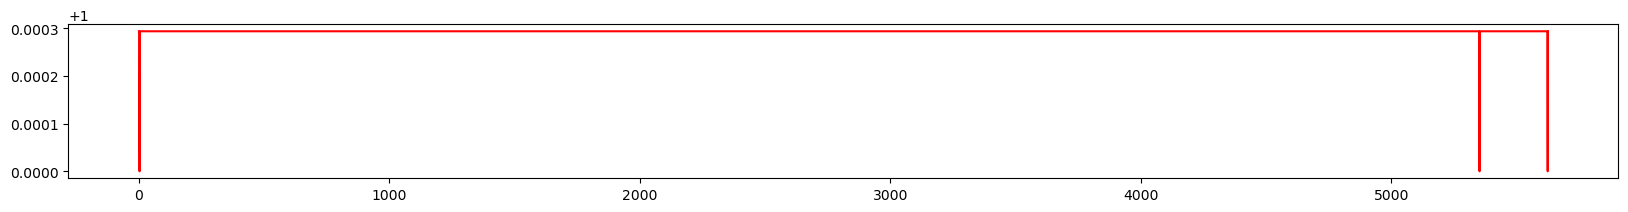

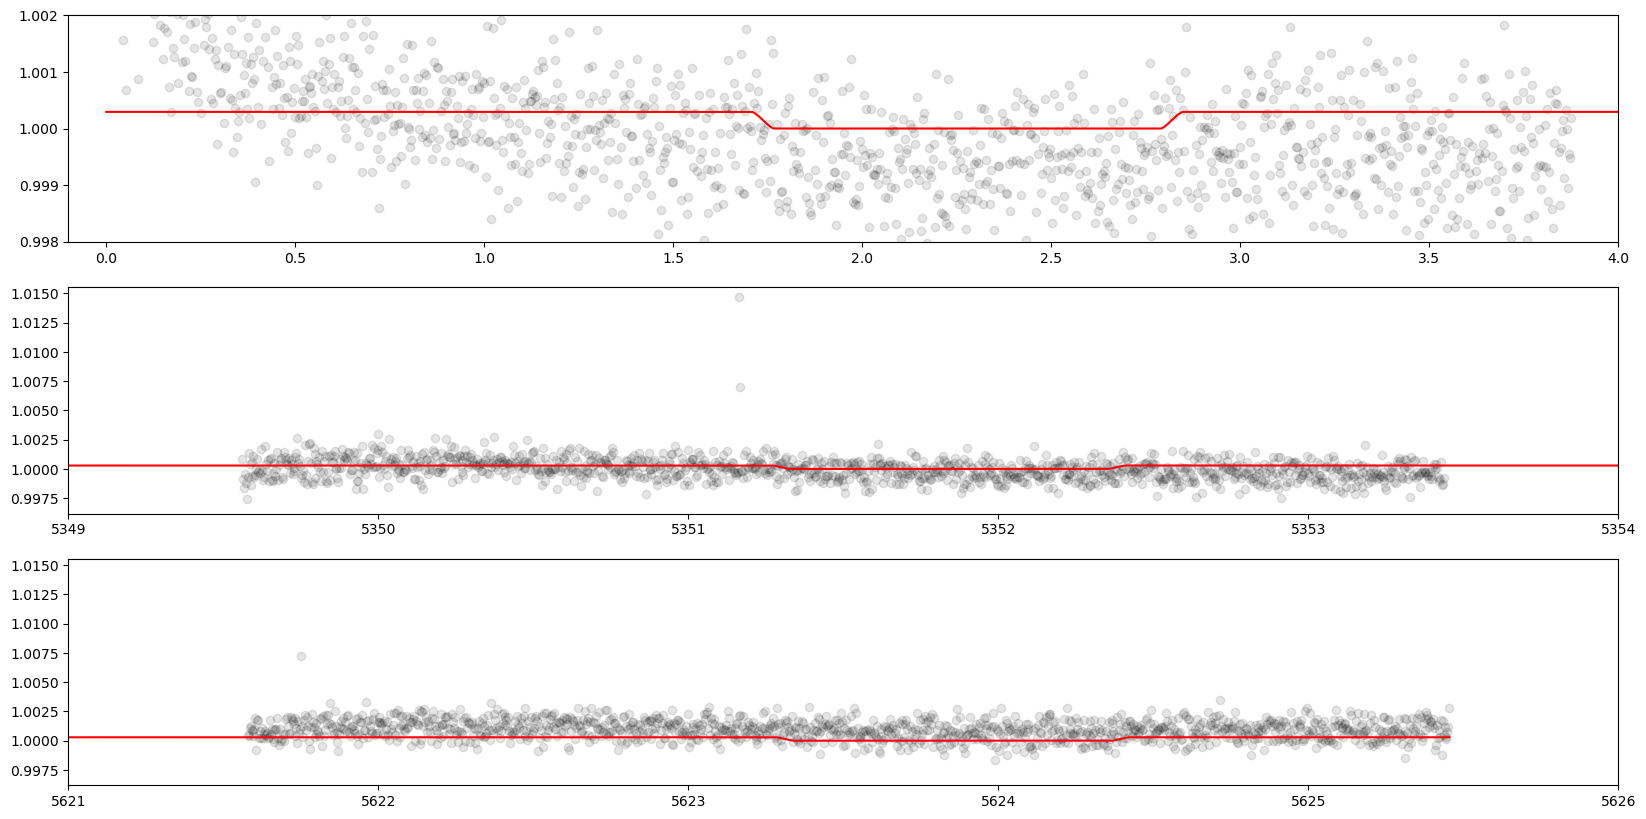

In [12]:
# plot the  eclipses with the raw flux
t_s = p0_mcmc[0]
fp = p0_mcmc[1]
flux = transit_model(time, t_s, fp)
plt.figure(figsize=(20, 2))
#plt.plot(time, aplev, 'ok', alpha=0.1)
plt.plot(time, flux, '-r')
#plt.xlim(5200, 5400)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].plot(time, aplev, 'ok', alpha=0.1)
ax[0].plot(time, flux, '-r')
ax[0].set_xlim(-0.1, 4)
ax[0].set_ylim(0.998, 1.002)
ax[1].plot(time, aplev, 'ok', alpha=0.1)
ax[1].plot(time, flux, '-r')
ax[1].set_xlim(5349, 5354)
ax[0].set_ylim(0.998, 1.002)
ax[2].plot(time, aplev, 'ok', alpha=0.1)
ax[2].plot(time, flux, '-r')
ax[2].set_xlim(5621, 5626)
ax[0].set_ylim(0.998, 1.002)

In [87]:
nbin = 100
time_segment_1 = time[:len1]
time_segment_2 = time[len1:len1+len2]
time_segment_3 = time[len1+len2:]
aplev_segment_1 = aplev[:len1]
aplev_segment_2 = aplev[len1:len1+len2]
aplev_segment_3 = aplev[len1+len2:]
aperr_segment_1 = aperr[:len1]
aperr_segment_2 = aperr[len1:len1+len2]
aperr_segment_3 = aperr[len1+len2:]

bins_time1, binErr_t = binValues(time_segment_1, time_segment_1, nbin)
bins_aplev1, binErr_aplev1 = binFluxError(aplev_segment_1, aperr_segment_1, time_segment_1, nbin)
bins_time2, binErr_t = binValues(time_segment_2, time_segment_2, nbin)
bins_aplev2, binErr_aplev2 = binFluxError(aplev_segment_2, aperr_segment_2, time_segment_2, nbin)
bins_time3, binErr_t = binValues(time_segment_3, time_segment_3, nbin)
bins_aplev3, binErr_aplev3 = binFluxError(aplev_segment_3, aperr_segment_3, time_segment_3, nbin)
bins_centroid_x1, binErr_centroid_x1 = binValues(centroid_x_segment_1, time_segment_1, nbin)
bins_centroid_y1, binErr_centroid_y1 = binValues(centroid_y_segment_1, time_segment_1, nbin)
bins_centroid_x2, binErr_centroid_x2 = binValues(centroid_x_segment_2, time_segment_2, nbin)
bins_centroid_y2, binErr_centroid_y2 = binValues(centroid_y_segment_2, time_segment_2, nbin)
bins_centroid_x3, binErr_centroid_x3 = binValues(centroid_x_segment_3, time_segment_3, nbin)
bins_centroid_y3, binErr_centroid_y3 = binValues(centroid_y_segment_3, time_segment_3, nbin)
# detec_model_poly(centroid_x_segment_1, centroid_y_segment_1, *p0_mcmc[2:8])
# detec_model_poly(centroid_x_segment_2, centroid_y_segment_2, *p0_mcmc[11:17])
# detec_model_poly(centroid_x_segment_3, centroid_y_segment_3, *p0_mcmc[21:27])

bins_detec1 = detec_model_poly(bins_centroid_x1, bins_centroid_y1, *p0_mcmc[2:8]) * exponential_func(bins_time1-time_segment_1[0], *p0_mcmc[8:11])
bins_detec2 = detec_model_poly(bins_centroid_x2, bins_centroid_y2, *p0_mcmc[11:17]) * double_exponential(bins_time2-time_segment_2[0], *p0_mcmc[17:21])
bins_detec3 = detec_model_poly(bins_centroid_x3, bins_centroid_y3, *p0_mcmc[21:27]) * exponential_func(bins_time3-time_segment_3[0], *p0_mcmc[27:30])
detec = np.concatenate([detec1, detec2, detec3])


In [57]:
# calculate RMS
residuals = (aplev/detec)-flux
rms = np.std(residuals)
print('RMS = ', rms*1e6, 'ppm')  

# # using convolution dont think this is right?
conv = np.convolve(aplev, residuals, mode='full')
rms2 = np.std(conv)
print('RMS2 = ', rms2)

# calculate chi2
chi2 = np.sum((residuals)**2 / (aperr)**2)
def chi_squared(aplev, astro, detec, p0_mcmc):    
    sigF = p0_mcmc[-1]
    sigma2 = sigF**2
    return np.sum((aplev - astro*detec) ** 2 / sigma2)

chi = chi_squared(aplev, flux, detec, p0_mcmc)
print('chi2 = ', chi)

# calculate BIC
def BIC(n_dat, n_par, lnL):
    return n_par*np.log(n_dat) - 2*lnL  

# lnL is the likelihood value of best fit model, formula that depends on chi2, recheck
bic = BIC(len(time), len(p0_mcmc), lnprobchain.max())
print('BIC:', bic)

# write to a text file with the same naming convention as the saved chains
textfile = savepath + 'results.txt'
with open(textfile, 'w') as f:
    f.write(out) # MCMC output
    f.write('RMS = '+str(rms*1e6)+' ppm\n')
    f.write('chi2 = '+str(chi)+'\n')
    f.write('BIC = '+str(bic)+'\n')
    f.write('RMS2 = '+str(rms2)+'\n')
    f.close()

RMS =  853.2870278662377 ppm
RMS2 =  0.012245469395884206
chi2 =  3790.1678679585293
BIC: -49385.88478825348


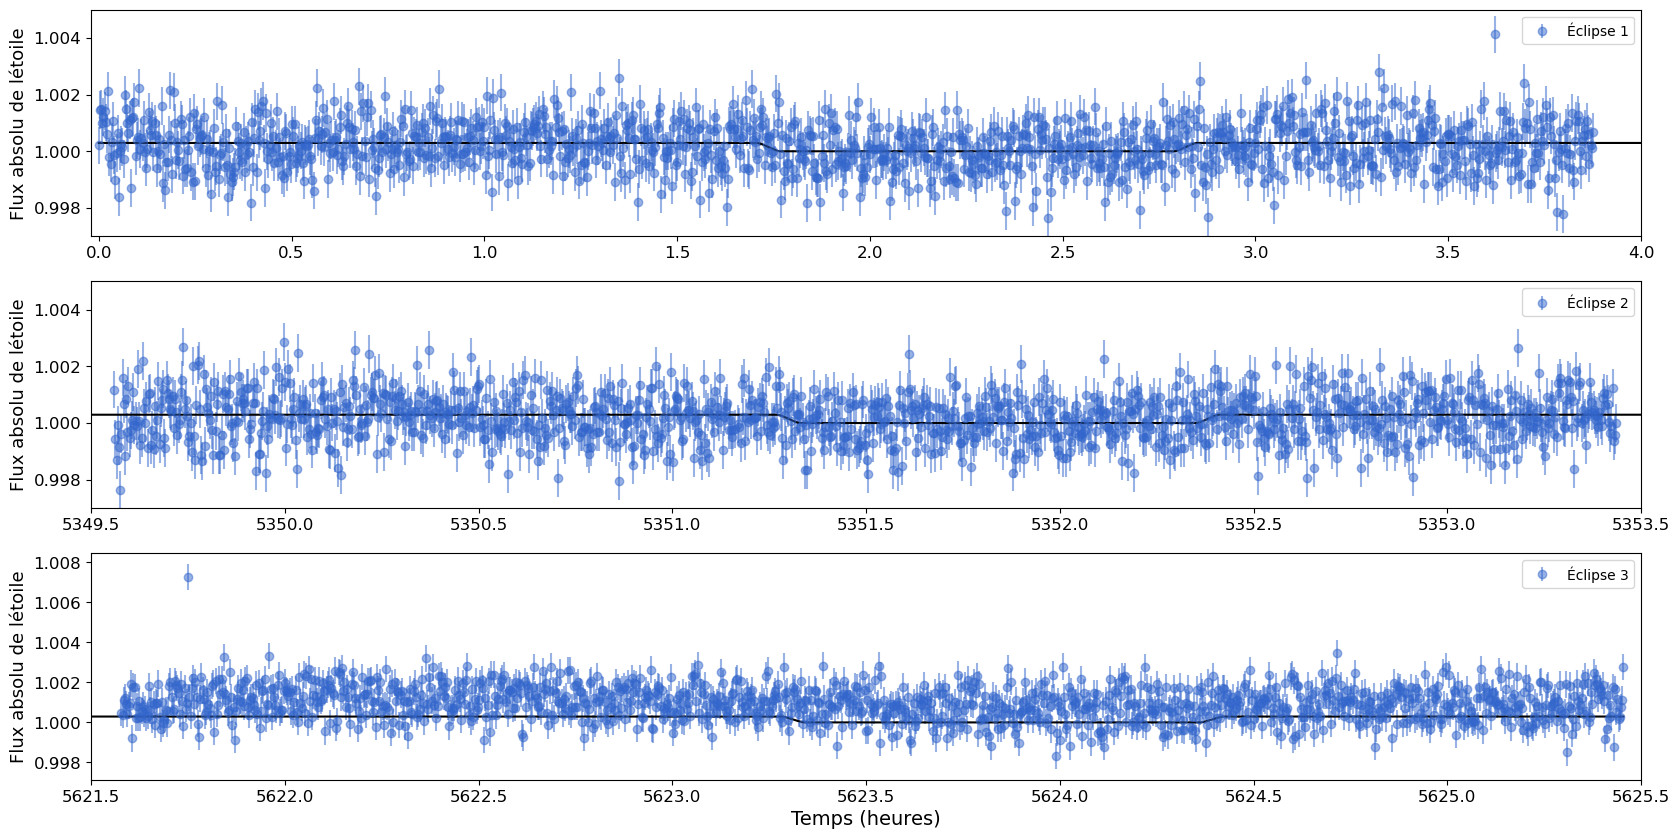

In [84]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
#ax[0].errorbar(bins_time1, bins_aplev1/bins_detec1, yerr= binErr_aplev1, linestyle='', marker='o', color='#3366cc', alpha=0.6, label='Éclipse 1')
ax[0].errorbar(time_segment_1, aplev_segment_1/detec1, yerr= aperr_segment_1, linestyle='', marker='o', color='#3366cc', alpha=0.5, label='Éclipse 1')
ax[0].plot(time, flux, '-k')
ax[0].set_xlim(-0.02, 4)
ax[0].set_ylim(0.997, 1.005)
#ax[1].errorbar(bins_time2, bins_aplev2/bins_detec2, yerr= binErr_aplev2, linestyle='', marker='o', color='#3366cc', alpha=0.6,  label='Éclipse 2')
ax[1].errorbar(time_segment_2, aplev_segment_2/detec2, yerr= aperr_segment_2, linestyle='', marker='o', color='#3366cc', alpha=0.5, label='Éclipse 2')
ax[1].plot(time, flux, '-k')
ax[1].set_xlim(5349.5, 5353.5)
ax[1].set_ylim(0.997, 1.005)
#ax[2].errorbar(bins_time3, bins_aplev3/bins_detec3, yerr= binErr_aplev3, linestyle='', marker='o', color='#3366cc', alpha=0.6, label='Éclipse 3')
ax[2].errorbar(time_segment_3, aplev_segment_3, yerr= aperr_segment_3, linestyle='', marker='o', color='#3366cc', alpha=0.5, label='Éclipse 3')
ax[2].plot(time, flux, '-k')
ax[2].set_xlim(5621.5, 5625.5)
ax[0].set_ylabel('Flux absolu de l''étoile', fontsize=13)
ax[1].set_ylabel('Flux absolu de l''étoile', fontsize=13)
ax[2].set_ylabel('Flux absolu de l''étoile', fontsize=13)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel('Temps (heures)', fontsize=14)
#plt.savefig('Joint_results/try'+try_nb+'.png')   
plt.show()

In [92]:
# eclipses
ecl = {}
ecl['1'] = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
ecl['2']  = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
ecl['3']  = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb')

for i, e in enumerate(ecl):
    ecl[e] = ecl[e].mjd
    ecl[e] = ecl[e]-time_arr[e][0]
    ecl[e] = ecl[e]*24 # convert to hours
    print(ecl[e])

time_seg = [time_segment_1, time_segment_2, time_segment_3]
detec_seg = [detec1, detec2, detec3] 
aplev_seg = [aplev_segment_1, aplev_segment_2, aplev_segment_3]
aperr_seg = [aperr_segment_1, aperr_segment_2, aperr_segment_3]
flux_seg = [transit_model(time_segment_1, t_s, fp), transit_model(time_segment_2, t_s, fp), transit_model(time_segment_3, t_s, fp)]

bins_time_seg = [bins_time1, bins_time2, bins_time3]
bins_aplev_seg = [bins_aplev1, bins_aplev2, bins_aplev3]
bins_detec_seg = [bins_detec1, bins_detec2, bins_detec3]
binErr_aplev_seg = [binErr_aplev1, binErr_aplev2, binErr_aplev3]
bins_flux_seg = [transit_model(bins_time1, t_s, fp), transit_model(bins_time2, t_s, fp), transit_model(bins_time3, t_s, fp)]



2.3647462059161626
2.3716723350808024
2.353039715671912


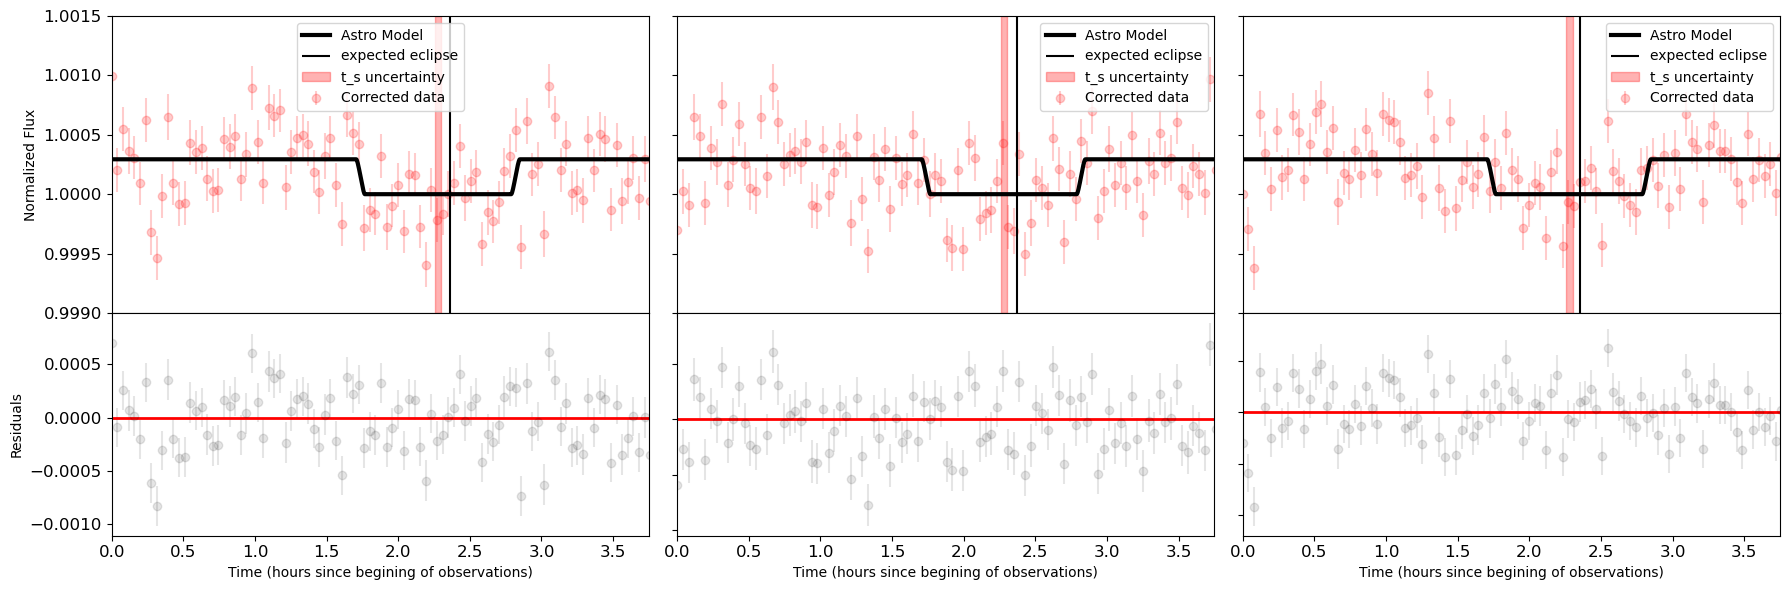

In [ ]:
#astro_bins = transit_model(bins_time, t_s, fp)
fig, ax = plt.subplots(2, 3, figsize=(18, 6),  gridspec_kw={'height_ratios': [4, 3]})

for i, e in enumerate(ecl):
    ax[0,i].errorbar(bins_time_seg[i]-bins_time_seg[i][0], bins_aplev_seg[i]/bins_detec_seg[i], yerr=binErr_aplev_seg[i], label='Corrected data', color='red', linestyle='none', alpha=0.2, marker='o', zorder=1)
    ax[0, i].plot(time, transit_model(time, t_s, fp), label='Astro Model',color = 'black', zorder=2, linewidth=3)
    ax[0, i].vlines(ecl[e], 0.994, 1.008, color='black', label='expected eclipse', zorder=3)
    ax[0, i].axvspan(t_s-MCMC_Results[0][2], t_s+MCMC_Results[0][1], color='red', alpha=0.3, label = 't_s uncertainty')
    ax[0, i].set_ylim(0.999, 1.0015)
    ax[0, i].set_xlim(0,3.75)
    ax[1,i].set_xlim(0,3.75)
    ax[0,i].legend()

    ## should residuals be binned instead of re-calculated
    res = (bins_aplev_seg[i]/bins_detec_seg[i])-bins_flux_seg[i]
    ax[1,i].errorbar(bins_time_seg[i]-bins_time_seg[i][0],res,yerr=binErr_aplev_seg[i],  label='Residuals', color='black', alpha=0.1, marker='o', linestyle='none')
    ax[1,i].axhline(y=0, color='r', linewidth = 2)
    fig.subplots_adjust(hspace=0)
    ax[1,i].set_xlabel('Time (hours since begining of observations)')
ax[0,0].set_ylabel('Normalized Flux') 
ax[0,1].set_yticklabels([])
ax[0,2].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[0,2].set_xticklabels([])
ax[1,0].set_ylabel('Residuals')
plt.tight_layout()  
plt.subplots_adjust(hspace=0)

plt.savefig('Final_Joint_results/try'+try_nb+'_binned.png')


2.3647462059161626


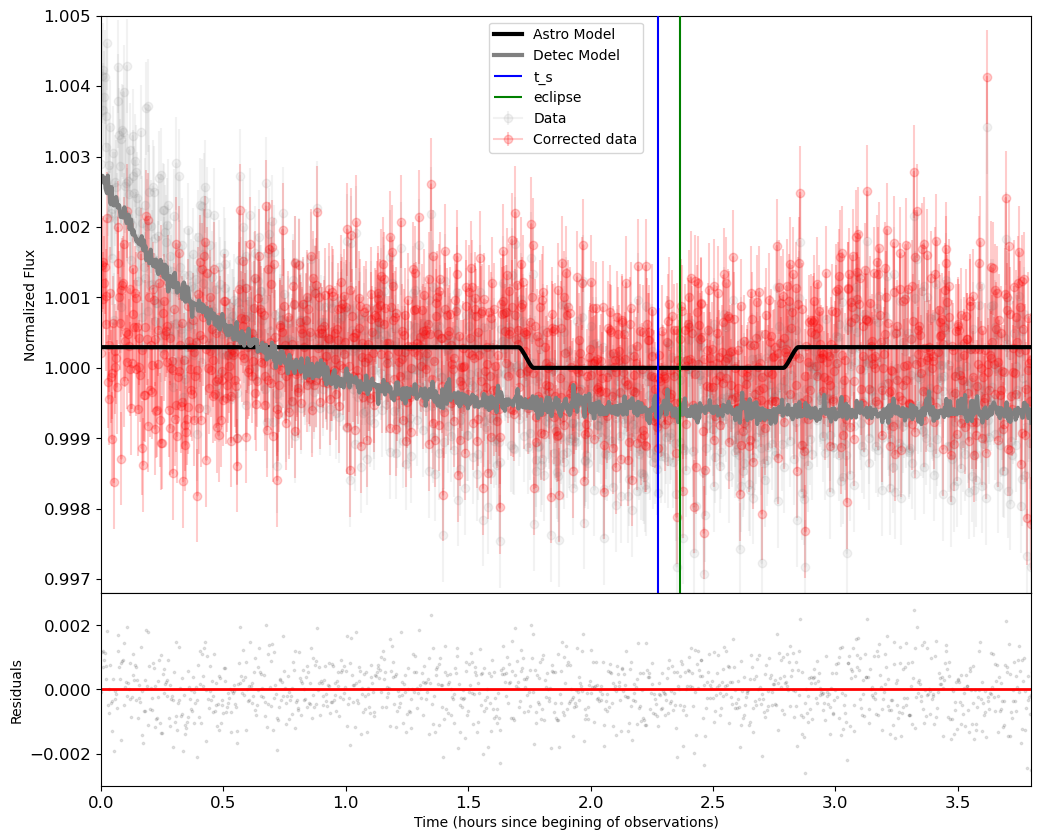

2.3716723350808024


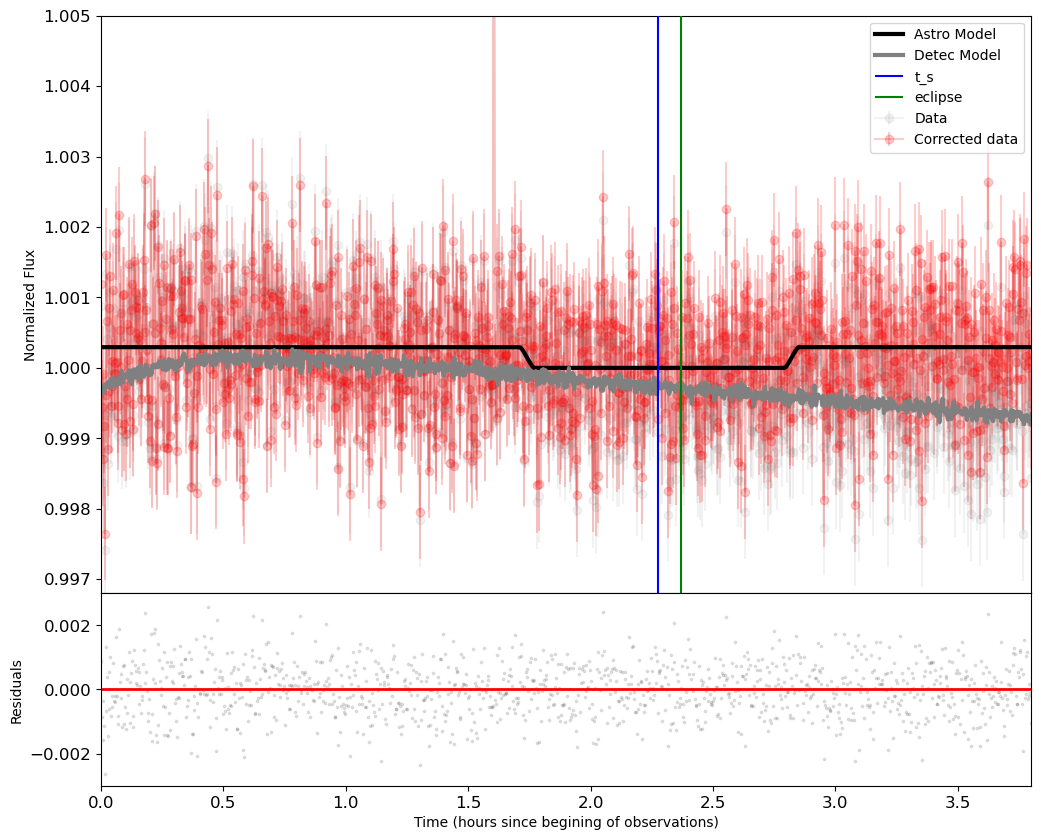

2.353039715671912


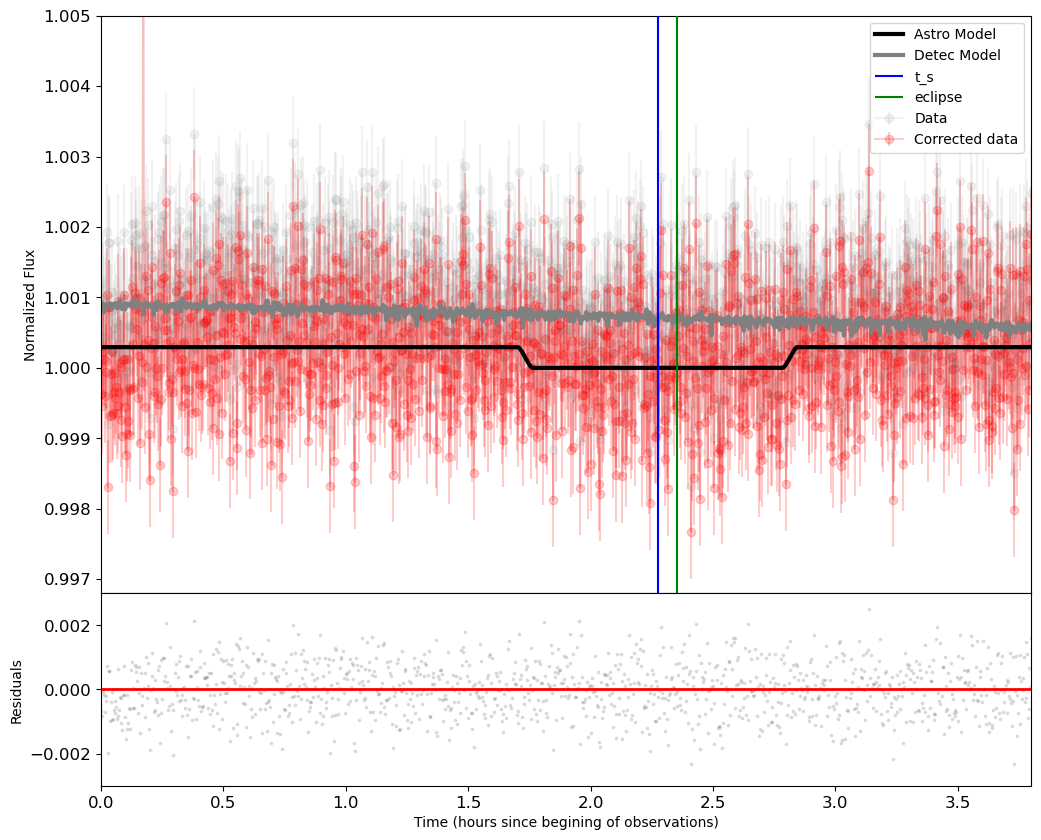

In [50]:
for i, e in enumerate(ecl):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10),  gridspec_kw={'height_ratios': [3, 1]})
    ax[0].errorbar(time_seg[i]-time_seg[i][0], aplev_seg[i], yerr =aperr_seg[i], label='Data', color='grey', alpha=0.1, marker='o', zorder=1)
    ax[0].errorbar(time_seg[i]-time_seg[i][0], aplev_seg[i]/detec_seg[i], yerr =aperr_seg[i], label='Corrected data', color='red', alpha=0.2, marker='o', zorder=1)
    ax[0].plot(time_seg[i]-time_seg[i][0], flux_seg[i], label='Astro Model',color = 'black', zorder=2, linewidth=3)
    ax[0].plot(time_seg[i]-time_seg[i][0], detec_seg[i], label='Detec Model', color = 'grey', zorder=2, linewidth=3)
    ax[0].vlines(t_s, 0.994, 1.008, color='blue', label='t_s', zorder=3)
    ax[0].vlines(ecl[e], 0.994, 1.008, color='green', label='eclipse', zorder=3)
    ax[0].set_ylim(0.9968, 1.005)
    ax[1].set_ylim(-0.003, 0.003)
    ax[0].set_xlim(0, 3.8)
    ax[1].set_xlim(0, 3.8)
    ax[0].legend()
    res = (aplev_seg[i]/detec_seg[i])-flux_seg[i]
    ax[1].scatter(time_seg[i]-time_seg[i][0],res, label='Residuals', color='black', alpha=0.1, marker='o', s=3)
    ax[1].axhline(y=0, color='r', linewidth = 2)
    ax[0].set_ylabel('Normalized Flux')
    ax[1].set_ylabel('Residuals')
    #hide y axis
    ax[0].set_xticks([])  # Remove x-axis ticks
    ax[0].set_xlabel('')  # Remove x-axis label

    # no h space
    plt.subplots_adjust(hspace=0.0)
    plt.xlabel('Time (hours since begining of observations)')
    plt.savefig('Final_Joint_results/try'+try_nb+'_ecl'+e+'.png', bbox_inches='tight')
    plt.show()

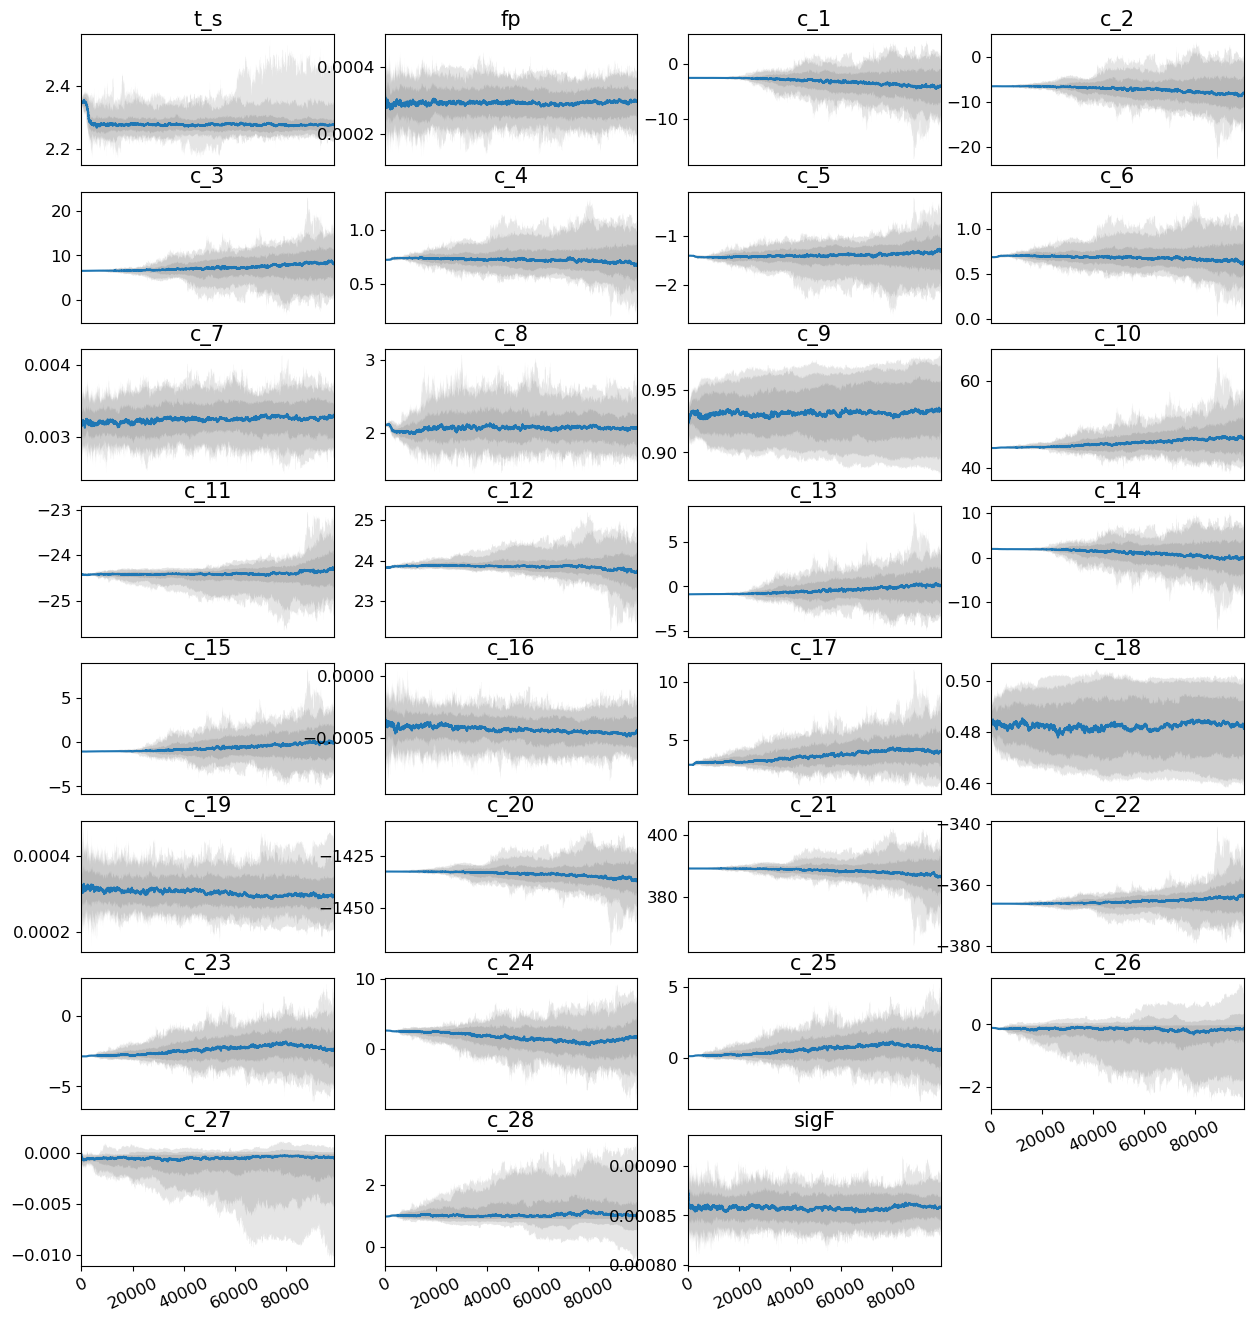

In [14]:
walk_style(chain, p0_labels, interv=10, fname='Final_Joint_results/try'+try_nb+'_walkers.png', showPlot=True, fontsize=15)

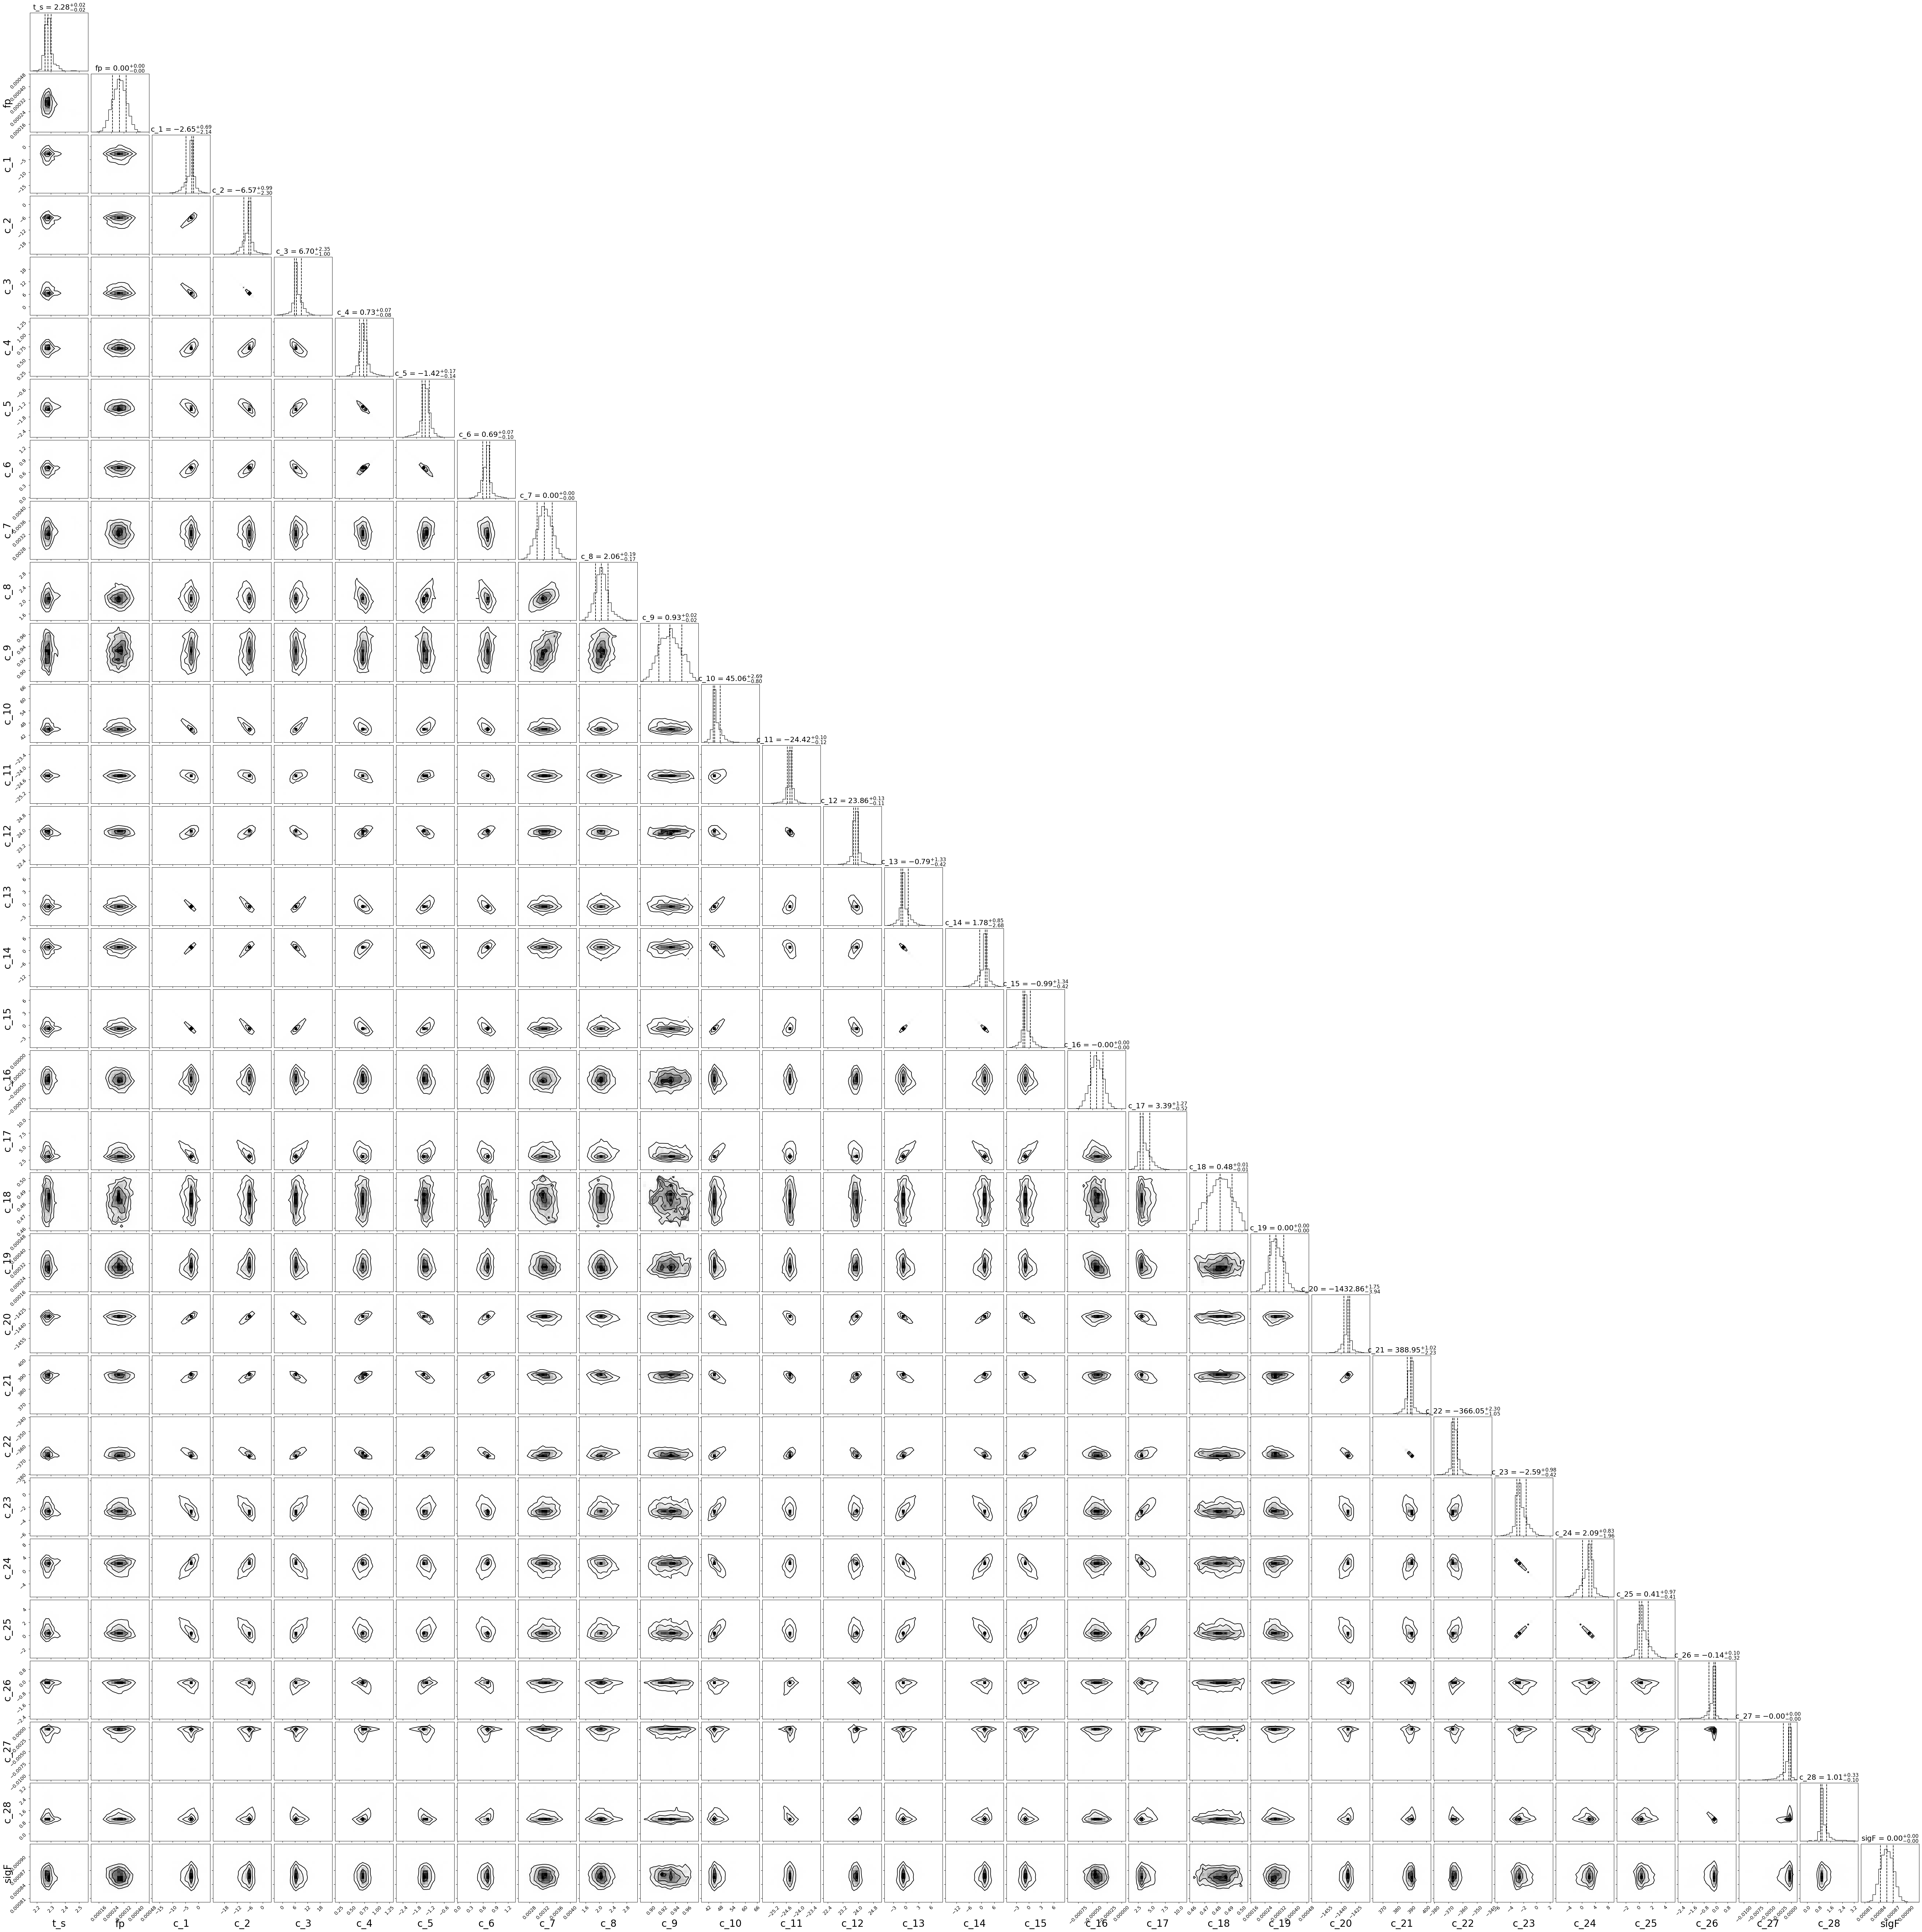

In [15]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

samples = chain.reshape((-1, ndim))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels = p0_labels, show_titles=True,
                        plot_datapoints=False, label_kwargs={"fontsize": 24}, title_kwargs={"fontsize": 18}, quiet=False)

fig.savefig('Final_Joint_results/try'+try_nb+'_corners.png')
#plt.close()

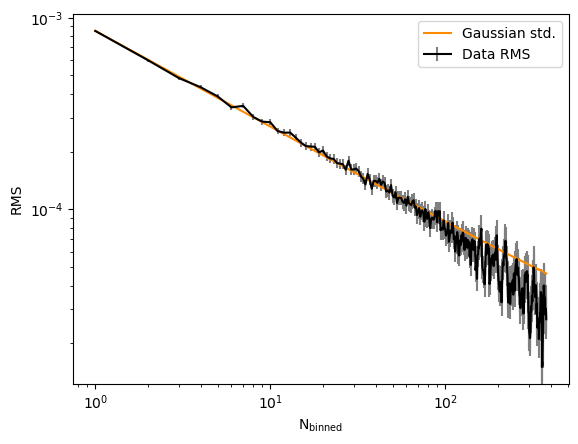

In [41]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fname=None, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    ax.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    ylim = ax.get_ylim()
    if occDuration is not None:
        ax.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    if showPlot:
        plt.show()
    
    plt.close()

plot_rednoise(residuals, 10, fname='Final_Joint_results/try'+try_nb+'_rednoise.png')

In [55]:
print('Time of mid eclipspe is ',(2.2778170852557573-ecl['1'])*-60,' before the expected time of mid-eclipse')

Time of mid eclipspe is  5.215747239624315  before the expected time of mid-eclipse
